In [3]:
import sys
import os
import json
import numpy as np
import time
sys.path.append('TradeEngine')
from TradeEngine.spot_futures.sProcess import sProcessBooks, sProcessTrades, sProcessOI, sProcessLiquidations
# from TradeEngine.spot_futures.mAggregator import mAggregator

ModuleNotFoundError: No module named 'TradeEngine'

# Content

- sProcessBooks: An example of processing books streams into a minute dataframe
- sProcessTrades: An example of processing trades streams into a minute dataframe
- sProcessOI: An example of processing books open interest into a minute dataframe
- sProcessLiquidations: An example of processing liquidations streams into a minute dataframe

# Forking

- Adjust dictionary accessing accoring to its keys

        current_second = int(trade[t_name] % 60)  
        self.current_second = current_second 
        current_price = # The logic of accessing the price
        amount = float(trade[l_name])

# Books


In [ ]:
initial_books = json.load(open('examples/data/binance_perp/books.json', 'r'))
trades = json.load(open('examples/data/binance_per/trades.json', 'r'))
books = json.load(open('examples/data/binance_perp/bupdates.json', 'r'))

btc_price = (float(initial_books['bids'][0][0]) + float(initial_books['asks'][0][0])) / 2

a  = sProcessBooks('binance', 'btc_usdt', btc_price, 20)
start =time.time()
a.update_books(initial_books, 'bids', 'asks', 'timestamp')
a.dfs_input_books()
for e in books:
    a.update_books(e, 'b', 'a', 'timestamp')
    a.dfs_input_books()
print(f"elapsed_time for {len(books)+1} iterations: ", time.time() - start)
a.snapshot.isna().sum().sum()
print(f"elapsed_time for {len(books)+1} iterations: ", time.time() - start)

# Trades

In [ ]:
trades = json.load(open('examples/data/binance_perp/trades.json', 'r'))

a  = sProcessTrades('binance', 'btc_usdt', btc_price, 20)
start = time.time()
for e in trades:
    a.dfs_input_trades(btc_price, e, 'timestamp', 'p', 'q')
print("elapsed_time : ", time.time() - start)

# Open Interest

In [ ]:
trades = json.load(open('examples/data/binance_perp/trades.json', 'r'))
a  = sProcessOI('binance', 'btc_usdt', btc_price, 20)
start = time.time()
for e in trades:
    a.dfs_input_OI(btc_price, e, 'timestamp', 'p', 'q')
print("elapsed_time : ", time.time() - start)

# Liquidations

In [ ]:
trades = json.load(open('examples/data/binance_perp/trades.json', 'r'))
a  = sProcessLiquidations('binance', 'btc_usdt', btc_price, 20)
start = time.time()
for e in trades:
    a.dfs_input_Liquidations(btc_price, e, 'timestamp', 'p', 'q')

print("elapsed : ", time.time() - start)

NOTES

In [1]:
import copy

initial_books = json.load(open('/content/SatoshiVault/examples/data/binance_perp/books.json', 'r'))
books = json.load(open('/content/SatoshiVault/examples/data/binance_perp/bupdates.json', 'r'))

btc_price = (float(initial_books['bids'][0][0]) + float(initial_books['asks'][0][0])) / 2

a  = sProcessBooks('binance', 'btc_usdt', btc_price, 20)
start =time.time()
a.update_books(initial_books, 'bids', 'asks', 'timestamp')
a.dfs_input_books()
for e in books:
    a.update_books(e, 'b', 'a', 'timestamp')
    a.dfs_input_books()
print(f"elapsed_time for {len(books)+1} iterations: ", time.time() - start)


binance = copy.copy(a)
okex = copy.copy(a)
bybit = copy.copy(a)

NameError: name 'json' is not defined

In [2]:
import pandas as pd

# Example DataFrames
data1 = {'ID': [1, 2, 3], 'Value': [10, 20, 30]}
data2 = {'ID': [2, 3, 4], 'Value': [40, 50, 60]}
data3 = {'ID': [1, 2, 3], 'Value': [70, 80, 90]}

df1 = pd.DataFrame(data1)
df2 = pd.DataFrame(data2)
df3 = pd.DataFrame(data3)

# Merge DataFrames with custom suffixes
merged_df = pd.merge(df1, df2, on='ID', how='outer', suffixes=('_df1', '_df2'))
merged_df = pd.merge(merged_df, df3, on='ID', how='outer', suffixes=('_df1_df2', '_df3'))

# Print the result
print(merged_df)

   ID  Value_df1  Value_df2  Value
0   1       10.0        NaN   70.0
1   2       20.0       40.0   80.0
2   3       30.0       50.0   90.0
3   4        NaN       60.0    NaN


In [4]:
def sort_columns(df):
    first_str_column = next(iter(df.columns))
    float_columns = [col for col in df.columns if col != first_str_column]
    sorted_columns = [first_str_column] + sorted(float_columns, key=float)
    sorted_df = df[sorted_columns]
    str_col = list(map(str, sorted_columns))
    sorted_df.columns = str_col
    return sorted_df

In [5]:
import pandas as pd
import numpy as np

def get_common_suffixes(n):
    """
        The maximum amount of datasets to aggregate is the len(alphabet). 
        Modify this function to get more aggregation possibilities
    """
    alphabet = 'xyzabcdefghijklmnopqrstuvw'
    suffixes = [f'_{alphabet[i]}' for i in range(n)]
    return suffixes

class sAggregatorUniversal():

    def __init__(self, identification, processes):
        self.identification = identification
        self.processes = processes
        self.snapshot = None
        self.suffixes = get_common_suffixes(len(processes))

    def merge_snapshots(self):
        """
            Any snapshot merger, books, OI, Liquidations, Trades
        """
        list_napshots = [
            sort_columns(df.snapshot) for df in self.processes
        ]


        for index, df in enumerate(list_napshots):
            if index == 0:
                merged_df = pd.merge(list_napshots[0], list_napshots[1], how='outer', left_index=True, right_index=True, suffixes=(self.suffixes[index], self.suffixes[index+1]))
            if index == len(list_napshots)-1:
                break
            if index != 0 and index != len(list_napshots)-1:
                merged_df = pd.merge(merged_df, list_napshots[index+1], how='outer', left_index=True, right_index=True, suffixes=(self.suffixes[index], self.suffixes[index+1]))
      
        common_columns_dic = {column.split("_")[0] : [] for column in merged_df.columns.tolist() }
        for column in merged_df.columns.tolist():
            common_columns_dic[column.split("_")[0]].append(column)
        
        sum = pd.DataFrame()
        for common_columns in common_columns_dic.keys():
            for index, column in enumerate(common_columns_dic[common_columns]):
                if index == 0:
                    sum[common_columns] = merged_df[column]
                else:
                    sum[common_columns] = sum[common_columns] + merged_df[column]

        self.snapshot = sum.copy()

        



level_range = 20

processes_ = [
    sProcessBooks('binance', 'btc_usdt', btc_price, level_range), 
    sProcessBooks('okx', 'btc_usdt', btc_price, level_range), 
    sProcessBooks('coinbase', 'btc_usd', btc_price, level_range),
    ]

b = sAggregatorUniversal('agg_books', processes_)


for process in b.processes:
  process.update_books(initial_books, 'bids', 'asks', 'timestamp')
  process.dfs_input_books()
  for e in books:
      process.update_books(e, 'b', 'a', 'timestamp')
      process.dfs_input_books()

b.merge_snapshots()

#b.snapshot

NameError: name 'sProcessBooks' is not defined

In [ ]:
level_range = 20

processes_ = [
    sProcessTrades('binance', 'btc_usdt', btc_price, level_range), 
    sProcessTrades('okx', 'btc_usdt', btc_price, level_range), 
    sProcessTrades('coinbase', 'btc_usd', btc_price, level_range),
    ]

t = sAggregatorUniversal('agg_books', processes_)


for process in t.processes:
  for e in trades:
      process.dfs_input_trades(btc_price, e, 'timestamp', 'p', 'q')

t.merge_snapshots()

#t.snapshot


In [6]:
df_books = b.snapshot.copy()
df_trades = t.snapshot.copy()

merged_df = pd.merge(df_books, df_trades, how='outer', left_index=True, right_index=True, suffixes=('_books', '_trades'))
common_columns = df_books.columns.intersection(df_trades.columns).tolist()

for column in common_columns:
    if "price" not in column:
      merged_df[column] = merged_df[column + '_books'].sub(merged_df[column + '_trades'], fill_value=0)
      merged_df = merged_df.drop([column + '_books', column + '_trades'], axis=1)
merged_df = merged_df.drop('price_trades', axis=1)
merged_df = merged_df.rename(columns={'price_books': 'price'})

merged_df = sort_columns(merged_df)

for index in range(len(merged_df)):
    if index != 0:
        merged_df.iloc[index-1] = merged_df.iloc[index].values - merged_df.iloc[index-1].values
merged_df = merged_df.drop(merged_df.index[-1])
merged_df = merged_df.var()


NameError: name 'b' is not defined

In [7]:

merged_df = pd.DataFrame([merged_df.values], columns=merged_df.index)



new_column_names = ["_".join([x.split('.')[0], "var"]) for x in merged_df.columns.tolist()]
merged_df = merged_df.rename(columns=dict(zip(merged_df.columns, new_column_names)))
merged_df

ValueError: Must pass 2-d input. shape=(1, 4, 4)

TypeError: only length-1 arrays can be converted to Python scalars

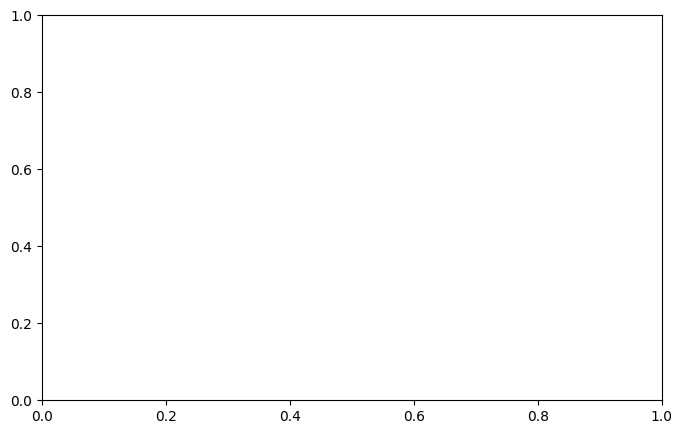

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.bar(merged_df.index.values, merged_df.values)
plt.title('Sample DataFrame Plot')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.show()

In [9]:
class m_Variance_books():
    """
        Processes heatmaps of variances of books  --  trades
        It is suppoused to capture weather spoofing, weather price chasers
    """

    def __init__ (self, processes, snap_length=744):

        """
          processes : Aggregator if books and trades . [0]  - books,  [1] --- trades. Must be consistent
          snap_length : The length of the snapshot to keep
        """

        self.processes = processes
        self.snapshot = None
        self.snap_length = snap_length

        def get_variances(self, current_price):

            df_books = processes[0]
            df_trades = t.snapshot.copy()

            merged_df = pd.merge(df_books, df_trades, how='outer', left_index=True, right_index=True, suffixes=('_books', '_trades'))
            common_columns = df_books.columns.intersection(df_trades.columns).tolist()

            for column in common_columns:
                if "price" not in column:
                  merged_df[column] = merged_df[column + '_books'].sub(merged_df[column + '_trades'], fill_value=0)
                  merged_df = merged_df.drop([column + '_books', column + '_trades'], axis=1)
            merged_df = merged_df.drop('price_trades', axis=1)
            merged_df = merged_df.rename(columns={'price_books': 'price'})

            merged_df = sort_columns(merged_df)

            for index in range(len(merged_df)):
                if index != 0:
                    merged_df.iloc[index-1] = merged_df.iloc[index].values - merged_df.iloc[index-1].values
            merged_df = merged_df.drop(merged_df.index[-1])
            merged_df = merged_df.var()
            merged_df = pd.DataFrame([merged_df.values], columns=merged_df.index)
            new_column_names = ["_".join([x.split('.')[0], "var"]) for x in merged_df.columns.tolist()]
            merged_df = merged_df.rename(columns=dict(zip(merged_df.columns, new_column_names)))
            self.snapshot = pd.concat([self.snapshot, merged_df.copy()], axis=0)

            if len(self.snapshot) > self.snap_length:
                self.snapshot = self.snapshot.drop(0)

SyntaxError: expected ':' (250007843.py, line 45)

In [ ]:
def ohelper_percentage_difference(center, value):
    if center == 0 and value > center:
        return float(100)
    if value == 0 and value < center:
        return float(9999999999)
    else:
        diff = value - center
        average = (center + value) / 2
        percentage_diff = (diff / average) * 100
        return percentage_diff

In [ ]:
current_price = 100

prices = [80, 93.22, 50.22, 100.22, 110, 190.22]


[ohelper_percentage_difference(current_price, price) for price in prices]


In [ ]:
def choose_range(current_price, level, level_ranges):
    
    pd = ohelper_percentage_difference(current_price, level)

    for index, r in enumerate(level_ranges):
        
        if index == 0 and pd < level_ranges[0]:
            return r

        elif index != 0 and index != len(level_ranges)-1 and pd >= level_ranges[index-1] and pd < level_ranges[index]:
            return r
        
        if index == len(level_ranges)-1 and pd >= level_ranges[index-1]:
            return t

In [ ]:
current_price = (float(initial_books['bids'][0][0]) + float(initial_books['asks'][0][0])) / 2

levels = np.array([0, 0.1, 0.2,  0.5, 0.75, 1.0, 2.0, 5.0, 10.0])
levels = np.sort(np.concatenate((levels, -1 * levels)))
levels = levels[(levels != -0)]
levels = np.append(levels, 100.0)

print(levels)

columns = [e.replace(".0", "").replace("-", "n_").replace(".", "_") for e in ["price"] + ["".join([str(x), "_var"]) for x in levels]]

new_df = pd.DataFrame(columns=columns)
 

df = merged_df.copy()

price_var = df["price_var"].values[0]

df = df.drop("price_var", axis=1)


columns_float = [float(x.split('_')[0]) for x in df.columns.tolist()]
values_ = df.values[0]
choosed_level = np.array([choose_range(current_price, v, levels) for v in columns_float])

# Do not forget about the 00000 columns

unique_values, indices = np.unique(choosed_level, return_inverse=True)
sums = [np.sum(values_[indices == val]) for val in unique_values]
print(sums, unique_values)

In [10]:
import numpy as np

# Given arrays
array_1 = np.array([-10., -5., -2., -1., -0.75, -0.5, -0.2, -0.1, 0.1, 0.2, 0.5, 0.75, 1., 2., 5., 10., 100.])
array_2 = np.array([-2., -1., -0.75, -0.5, -0.2, -0.1, 0.1, 0.2, 0.5, 0.75, 1., 2., 5.])
array_3 = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 427.71, 29.6, 14.76])

array_4 = np.zeros_like(array_1)
#array_3_ = np.pad(array_3, (0, len(array_1) - len(array_2)), 'constant')

common_indices = np.isin(array_1, array_2)

common_indices

array([False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False])

In [11]:
import numpy as np

array1 = np.array([-10., -5., -2., -1., -0.75, -0.5, -0.2, -0.1, 0.1, 0.2, 0.5, 0.75, 1., 2., 5., 10., 100.])
array2 = np.array([-2., -1., -0.75, -0.5, -0.2, -0.1, 0.1, 0.2, 0.5, 0.75, 1., 2., 5.])
array3 = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 427.71, 29.6, 14.76])

def g(array1, array2, array3):
    array4 = np.zeros_like(array1)
    for i in range(len(array1)):
        if array1[i] in array2:
            array4[i] = array3[array2.tolist().index(array1[i])]
    return array4

array4 = g(array1.copy(), array2.copy(), array3.copy())
print(array4)

[  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.   427.71  29.6   14.76   0.     0.  ]
